The following notebook is based on the [excerpt from the Python Data Science Handbook by Jake VanderPla](https://jakevdp.github.io/PythonDataScienceHandbook/05.10-manifold-learning.html). 

In [1]:
# Data wrangling
import numpy as np
import pandas as pd
import collections

# Data visualisation
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
%matplotlib inline
        
# Dimensionality reduction
from sklearn.decomposition import PCA 
from sklearn.manifold import MDS, TSNE, Isomap
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import scale
import umap

# Clustering
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans, MeanShift, DBSCAN
import hdbscan
from scipy.cluster.hierarchy import dendrogram, linkage

/home/kzkedzierska/miniconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/kzkedzierska/miniconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', 
            va='center', ha='center', 
            weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

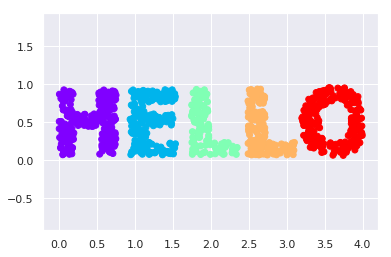

In [3]:
X = make_hello(1000)
colorize = dict(c = X[:, 0], 
                cmap = plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

## Rotated HELLO

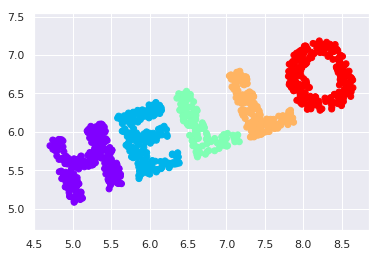

In [4]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

# Multidimensional Scaling (MDS)

## Distance

In [5]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

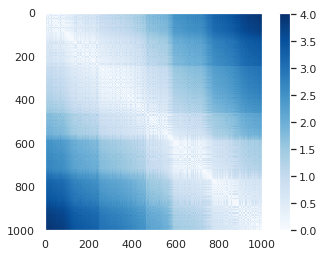

In [6]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar()

Distance of the rotated dataset

In [7]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

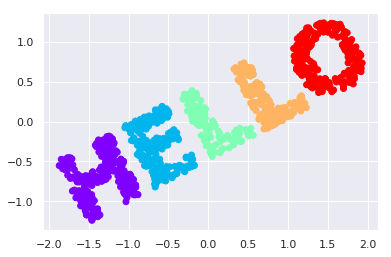

In [8]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

In [9]:
HELLO_dt = pd.DataFrame()
supported_types = {
        "PCA" : PCA(n_components = 2),
        "TSNE" : TSNE(), 
        "UMAP" : umap.UMAP(n_components = 2), 
        "MDS" : MDS(n_components = 2),
        "ISOMAP": Isomap(n_components = 2)
    }

for typ in supported_types.keys():
    typ = typ.upper()

    reducer = supported_types[typ]

    X_transformed = reducer.fit_transform(X)
    HELLO_dt['x_' + typ] = X_transformed[:, 0]
    HELLO_dt['y_' + typ] = X_transformed[:, 1]

# plt.scatter(out_umap[:, 0], out_umap[:, 1], **colorize)
# plt.axis('equal');

/home/kzkedzierska/miniconda3/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components


In [10]:
HELLO_dt.describe()

,x_PCA,y_PCA,x_TSNE,y_TSNE,x_UMAP,y_UMAP,x_MDS,y_MDS,x_ISOMAP,y_ISOMAP
count,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,-2.273737e-16,3.472778e-16,-1.091706,1.430982,-0.709959,-0.577647,1.136868e-16,2.842171e-17,-9.992007e-18,-9.547918e-18
std,1.228592e+00,2.651626e-01,25.524939,22.875790,7.952453,8.301994,1.194426e+00,3.912696e-01,2.028577e-01,2.002510e-01
min,-1.915044e+00,-4.250757e-01,-53.208157,-32.687649,-15.510053,-15.236898,-1.920600e+00,-8.475751e-01,-6.627848e-01,-7.785840e-01
25%,-1.027304e+00,-2.546324e-01,-20.570477,-18.540624,-6.815676,-5.626752,-1.042918e+00,-2.954220e-01,-2.791569e-03,-4.742226e-04
50%,-9.980875e-02,7.384006e-03,-3.012089,-3.104684,0.054796,-0.509185,-9.597360e-02,1.228480e-02,-2.237598e-03,4.897063e-03
75%,1.090087e+00,2.429377e-01,20.907448,20.889636,5.053077,7.067724,9.715703e-01,3.176381e-01,-3.467577e-04,6.435489e-03
max,2.080786e+00,4.711798e-01,42.272034,45.638008,14.210920,13.698812,2.048971e+00,8.002831e-01,6.638226e-01,8.741847e-01


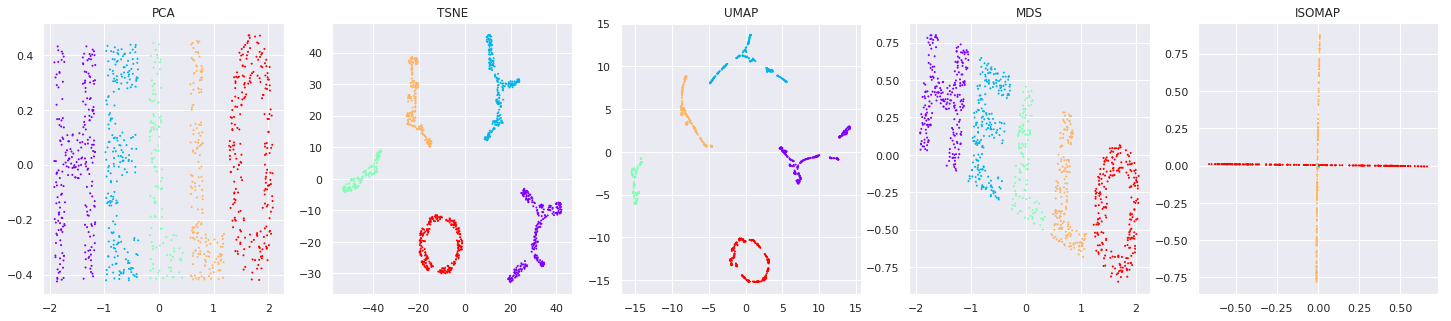

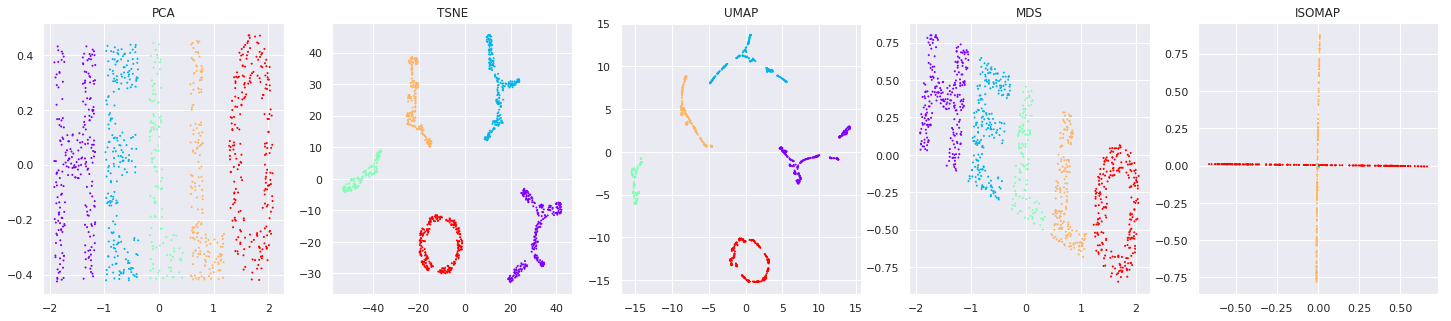

In [11]:
analysis_types = list(supported_types.keys())
def plot_all(df_with_coord, labels = None, 
             types = analysis_types, marker_size = 0.25):
    fig = plt.figure(figsize = (25, 5))
    for i in range(0, len(types)):
        analysis_type = types[i]
        # plotting
        plt.subplot(1, len(types), i + 1)
        if labels is not None:
            plt.scatter(df_with_coord['x_' + analysis_type], 
                        df_with_coord['y_' + analysis_type], 
                        **labels, s = marker_size)
        else:
            plt.scatter(df_with_coord['x_' + analysis_type], 
                        df_with_coord['y_' + analysis_type],
                        marker_size)
        plt.title(analysis_type)
    return fig

plot_all(HELLO_dt, labels = colorize, marker_size = 1)

In [12]:
HELLO_dt[['x_PCA', 'y_PCA']].describe()

,x_PCA,y_PCA
count,1.000000e+03,1.000000e+03
mean,-2.273737e-16,3.472778e-16
std,1.228592e+00,2.651626e-01
min,-1.915044e+00,-4.250757e-01
25%,-1.027304e+00,-2.546324e-01
50%,-9.980875e-02,7.384006e-03
75%,1.090087e+00,2.429377e-01
max,2.080786e+00,4.711798e-01


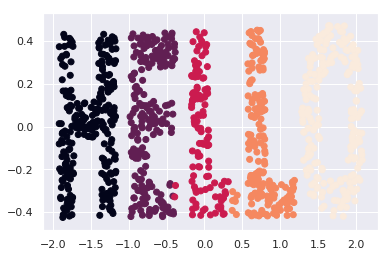

In [13]:
kmeans = KMeans(n_clusters = 5, random_state = 7).fit(HELLO_dt[['x_PCA', 'y_PCA']])
labels = kmeans.labels_

plt.scatter(HELLO_dt['x_PCA'], HELLO_dt['y_PCA'], c=pd.factorize(labels)[0])

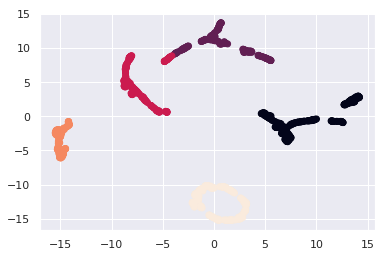

In [14]:
kmeans = KMeans(n_clusters = 5, random_state = 7).fit(HELLO_dt[['x_UMAP', 'y_UMAP']])
labels = kmeans.labels_

plt.scatter(HELLO_dt['x_UMAP'], HELLO_dt['y_UMAP'], c=pd.factorize(labels)[0])

In [15]:
hdbscan_labels = hdbscan.HDBSCAN().fit_predict(HELLO_dt[['x_UMAP', 'y_UMAP']])

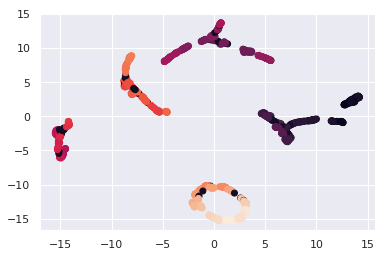

In [16]:
plt.scatter(HELLO_dt['x_UMAP'], HELLO_dt['y_UMAP'], c=pd.factorize(hdbscan_labels)[0])

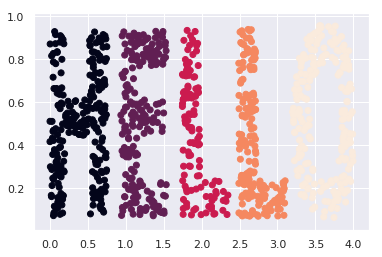

In [17]:
hdbscan_labels = hdbscan.HDBSCAN().fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=pd.factorize(hdbscan_labels)[0])

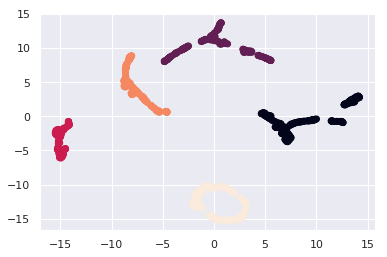

In [18]:
plt.scatter(HELLO_dt['x_UMAP'], HELLO_dt['y_UMAP'], c=pd.factorize(hdbscan_labels)[0])

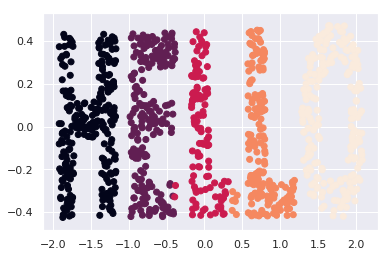

In [19]:
kmeans = KMeans(n_clusters = 5, random_state = 7).fit(HELLO_dt[['x_PCA', 'y_PCA']])
labels = kmeans.labels_

plt.scatter(HELLO_dt['x_PCA'], HELLO_dt['y_PCA'], c=pd.factorize(labels)[0])